In [2]:
!pip3 install -r requirements.txt

  Obtaining dependency information for pillow>=7.0.0 from https://files.pythonhosted.org/packages/b7/ad/71982d18fd28ed1f93c31b8648f980ebdbdbcf7d8c9c9b4af59290914ce9/Pillow-10.0.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for requests>=2.20.0 from https://files.pythonhosted.org/packages/70/8e/0e2d847013cb52cd35b38c009bb167a1a26b2ce6cd6965bf26b47bc0bf44/requests-2.31.0-py3-none-any.whl.metadata
  Obtaining dependency information for opencv-python>=4.2.0.32 from https://files.pythonhosted.org/packages/32/a6/4321f0f30ee11d6d85f49251d417f4e885fe7638b5ac50b7e3c80cccf141/opencv_python-4.8.0.76-cp37-abi3-macosx_11_0_arm64.whl.metadata
  Using cached opencv_python-4.8.0.76-cp37-abi3-macosx_11_0_arm64.whl.metadata (19 kB)
  Obtaining dependency information for tqdm>=4.23.0 from https://files.pythonhosted.org/packages/00/e5/f12a80907d0884e6dff9c16d0c0114d81b8cd07dc3ae54c5e962cc83037e/tqdm-4.66.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import pandas as pd
df = pd.read_csv('GPTNameTHEN.txt', sep=".", header=None, index_col=0)

In [2]:
df.columns = ["Name"]
df.head()

,Name
0,
1,สมชาย ใจดี (Somchai Jai Dee)
2,รุ่งทิวา สวยงาม (Rungtiwa Suayngam)
3,ภัทราพร รักชาติ (Patharaporn Rukchat)
4,อรวรรณ มีรักษ์ (Orawan Mee-rak)
5,ณัฐวรรณ สุขใจ (Nattawan Sukjai)


In [3]:
import regex as re
def en_th_sep(name = 'name'):
    name = name.split('(')
    name[1] = name[1].replace(')', '')
    name[0] = name[0].strip()
    if re.search(r'[ก-๙]', name[0]):
        return name[1], name[0]
    else:
        return name[0], name[1]

In [4]:
df['en'], df['th'] = zip(*df['Name'].map(en_th_sep))

In [5]:
df = df.drop(columns=['Name'])
df.head()

,en,th
0,,
1,Somchai Jai Dee,สมชาย ใจดี
2,Rungtiwa Suayngam,รุ่งทิวา สวยงาม
3,Patharaporn Rukchat,ภัทราพร รักชาติ
4,Orawan Mee-rak,อรวรรณ มีรักษ์
5,Nattawan Sukjai,ณัฐวรรณ สุขใจ


In [6]:
from trdg.utils import mask_to_bboxes, draw_bounding_boxes

In [9]:
from trdg.generators import (
    GeneratorFromStrings )

# The generators use the same arguments as the CLI, only as parameters
generator = GeneratorFromStrings(
    # df['th'].tolist() + df['en'].tolist(),
    ['นั่น', 'น่ัน', 'พี่', 'พ่ี', 'น้ำ', 'นำ้'],
    blur=0,
    random_blur=False,
    language='th',
    # count=len(df['th'].tolist())*2,
    count=6,
    fonts=[
        'trdg/fonts/th/upcdb.ttf', 
        # 'trdg/fonts/th/upcdbi.ttf',
        # 'trdg/fonts/th/upcdi.ttf', 
        'trdg/fonts/th/upcdl.ttf',
    ],
    size=64,
    background_type=3,
    image_dir='thai_id_bg/',
    margins = (5,5,5,5),
    output_mask=True,
    output_bboxes=3,
)   

['นั่', 'น']
นั่น
[(4, 12, 29, 59), (27, 35, 52, 59)]


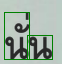

['นั่', 'น']
น่ัน
[(4, 11, 31, 59), (25, 36, 47, 59)]


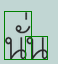

['พี่']
พี่
[(4, 12, 29, 59)]


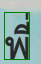

['พี่']
พ่ี
[(4, 11, 26, 59)]


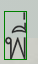

['น้ำ']
น้ำ
[(4, 7, 40, 59)]


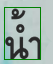

['น้ำ']
นำ้
[(4, 9, 37, 58)]


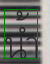

In [10]:
from PIL import ImageDraw
for (img, mask), lbl in generator:
    print(lbl)
    bboxes = mask_to_bboxes(mask)
    print(bboxes)
    d = ImageDraw.Draw(img)
    for bbox in bboxes:
        d.rectangle(bbox, outline="green")
    display(img)

# trdg save for mmocr by P Earth

In [58]:
import time
import os
from tqdm import tqdm
from pyblp import save_pickle

def current_milli_time():
    return round(time.time() * 1000)

project_dir = 'ThaiID'
full_path =os.path.dirname(os.path.realpath("__file__"))
project_dir = os.path.join(full_path,project_dir)
dirname = 'train'
dir_path = os.path.join(project_dir,dirname)
os.makedirs(dir_path,exist_ok=True)
texts = []
save_dir_img =os.path.join(dir_path,'imgs')
# rmtree(save_dir_img,ignore_errors=True)
os.makedirs(save_dir_img,exist_ok=True)

save_dir_bbox =os.path.join(dir_path,'bbox')
# rmtree(save_dir_bbox,ignore_errors=True)
os.makedirs(save_dir_bbox,exist_ok=True)

save_dir_mask =os.path.join(dir_path,'mask')
# rmtree(save_dir_mask,ignore_errors=True)
os.makedirs(save_dir_mask,exist_ok=True)

for i in tqdm(generator):
    if i[0]:
        (img, mask), lbl = i
        try:
            # lbl = lbl.replace('—','')
            # display(img)
            bbox = mask_to_bboxes(mask)
            timestamp = current_milli_time()
            filename = f'{timestamp}.jpg'
            filename_mask = f'{timestamp}.png'
            bbox_filename = f'{timestamp}.pkl'
            image_path = os.path.join(save_dir_img,filename)
            bbox_path = os.path.join(save_dir_bbox,bbox_filename)

            mask_path = os.path.join(save_dir_mask,filename_mask)
            save_pickle(bbox, bbox_path)
            # txt_imagepath =os.path.join('test',filename)

            # resized = img.resize((340,70))
            img.save(image_path)
            mask.save(mask_path)
            texts.append(f'{filename} {lbl}\n')
        # print(lbl)
        except Exception as e:
            print(e)
            print(lbl)
with open(os.path.join(dir_path,'gt.txt'),'a') as f:
    f.writelines(''.join(texts))

5it [00:00, 41.51it/s]

['ส', 'ม', 'ช', 'า', 'ย', ' ', 'ใ', 'จ', 'ดี']
['รุ่', 'ง', 'ทิ', 'ว', 'า', ' ', 'ส', 'ว', 'ย', 'ง', 'า', 'ม']
['ภั', 'ท', 'ร', 'า', 'พ', 'ร', ' ', 'รั', 'ก', 'ช', 'า', 'ติ']
['อ', 'ร', 'ว', 'ร', 'ร', 'ณ', ' ', 'มี', 'รั', 'ก', 'ษ์']
['ณั', 'ฐ', 'ว', 'ร', 'ร', 'ณ', ' ', 'สุ', 'ข', 'ใ', 'จ']
['จ', 'อ', 'ห์', 'น', ' ', 'ส', 'มิ', 'ธ']
['แ', 'ม', 'รี', ' ', 'จ', 'อ', 'ห์', 'น', 'สั', 'น']
['เ', 'ด', 'วิ', 'ด', ' ', 'บ', 'ร', 'า', 'ว', 'น์']
['เ', 'ซ', 'ร่', 'า', ' ', 'ด', 'า', 'วิ', 'ส']


15it [00:00, 43.51it/s]

['ไ', 'ม', 'เ', 'คิ', 'ล', ' ', 'วิ', 'ล', 'สั', 'น']
['อ', 'ริ', 'ย', 'า', ' ', 'สุ', 'ข', 'ส', 'ม', 'บั', 'ติ']
['ป', 'ร', 'า', 'ณี', ' ', 'วิ', 'ไ', 'ล', 'รั', 'ต', 'น์']
['วิ', 'ชิ', 'ต', ' ', 'ห', 'า', 'ญ', 'ก', 'ล้', 'า']
['อ', 'า', 'รี', 'ย์', ' ', 'น', 'ว', 'ล', 'เ', 'พ็', 'ช', 'ร์']
['ช', 'า', 'ค', 'ริ', 'ต', ' ', 'ลิ้', 'ม', 'สุ', 'ข']
['เ', 'จ', 'ส', 'สิ', 'ก้', 'า', ' ', 'มิ', 'ล', 'เ', 'ล', 'อ', 'ร์']
['ค', 'ริ', 'ส', 'โ', 'ต', 'เ', 'ฟ', 'อ', 'ร์', ' ', 'วิ', 'ล', 'สั', 'น']
['เ', 'อ', 'ลิ', 'ซ', 'า', 'เ', 'บ', 'ธ', ' ', 'เ', 'ท', 'เ', 'ล', 'อ', 'ร์']


25it [00:00, 39.23it/s]

['แ', 'ม', 'ท', 'ธิ', 'ว', ' ', 'จ', 'อ', 'ห์', 'น', 'สั', 'น']
['แ', 'อ', 'ม', 'า', 'น', 'ด้', 'า', ' ', 'ด', 'า', 'วิ', 'ส']
['ชั', 'ช', 'ว', 'า', 'ล', ' ', 'สุ', 'ข', 'ส', 'า', 'ธ', 'า', 'ร', 'ณ์']
['วิ', 'ลั', 'ย', ' ', 'พ', 'ง', 'ศ์', 'ศิ', 'ริ']
['สุ', 'ธี', ' ', 'ว', 'ง', 'ศ์', 'เ', 'จ', 'ริ', 'ญ']
['ศุ', 'ภ', 'ณั', 'ฐ', ' ', 'ม', 'า', 'ก', 'มี']
['นิ', 'ภ', 'า', 'พ', 'ร', ' ', 'รั', 'ก', 'ษ', 'า']
['เ', 'จ', 'น', 'นิ', 'เ', 'ฟ', 'อ', 'ร์', ' ', 'แ', 'อ', 'น', 'เ', 'ด', 'อ', 'ร์', 'สั', 'น']


33it [00:00, 36.69it/s]

['ริ', 'ช', 'า', 'ร์', 'ด', ' ', 'ม', 'า', 'ร์', 'ติ', 'เ', 'น', 'ซ']
['แ', 'พ', 'ท', 'ริ', 'เ', 'ซี', 'ย', ' ', 'ไ', 'ว', 'ท์']
['แ', 'ด', 'เ', 'นี', 'ย', 'ล', ' ', 'ลี']
['ลิ', 'น', 'ด', 'า', ' ', 'แ', 'ฮ', 'ริ', 'ส']
['ธี', 'ร', 'ะ', 'พั', 'ฒ', 'น์', ' ', 'ห', 'า', 'ญ', 'ใ', 'จ']
['ป', 'วี', 'ณ', 'า', ' ', 'ช', 'า', 'ติ', 'ไ', 'พ', 'ศ', 'า', 'ล']
['กิ', 'ต', 'ติ', 'ย', 'า', ' ', 'สุ', 'ท', 'ธิ', 'ป', 'ร', 'ะ', 'ภ', 'า']
['ช', 'นั', 'ญ', 'ชิ', 'ต', ' ', 'บุ', 'ญ', 'ยื', 'น']


41it [00:01, 37.10it/s]

['ไ', 'ร', 'อั', 'น', ' ', 'จ', 'อ', 'ห์', 'น', 'สั', 'น']
['เ', 'อ', 'มิ', 'ลี่', ' ', 'ม', 'า', 'ร์', 'ติ', 'น']
['นิ', 'โ', 'ค', 'ลั', 'ส', ' ', 'ด', 'า', 'วิ', 'ส']
['คิ', 'ม', 'เ', 'บ', 'อ', 'ร์', 'ลี่', ' ', 'ค', 'ล', 'า', 'ร์', 'ก']
['เ', 'จ', 'สั', 'น', ' ', 'วิ', 'ล', 'สั', 'น']
['สุ', 'ภ', 'า', 'ว', 'ดี', ' ', 'ม', 'ณี', 'ส', 'วั', 'ส', 'ดิ์']
['พิ', 'ช', 'ญ', 'า', ' ', 'รั', 'ก', 'เ', 'พ็', 'ช', 'ร์']
['รั', 'ช', 'นี', 'ก', 'ร', ' ', 'สุ', 'ข', 'ส', 'ม', 'บั', 'ติ']


50it [00:01, 38.83it/s]

['วิ', 'ภ', 'า', 'ว', 'ดี', ' ', 'พ', 'ง', 'ศ์', 'พิ', 'ริ', 'ย', 'ะ']
['ณั', 'ฐ', 'ช', 'ย', 'า', ' ', 'ม', 'ง', 'ค', 'ล', 'ส', 'วั', 'ส', 'ดิ์']
['วิ', 'ล', 'เ', 'ลี', 'ย', 'ม', ' ', 'บ', 'ร', 'า', 'ว', 'น์']
['มิ', 'เ', 'ช', 'ล', ' ', 'จ', 'อ', 'ห์', 'น', 'สั', 'น']
['โ', 'จ', 'เ', 'ซ', 'ฟ', ' ', 'ด', 'า', 'วิ', 'ส']
['แ', 'อ', 'ม', 'า', 'น', 'ด้', 'า', ' ', 'มิ', 'ล', 'เ', 'ล', 'อ', 'ร์']
['เ', 'บ', 'น', 'จ', 'า', 'มิ', 'น', ' ', 'วิ', 'ล', 'สั', 'น']
['ว', 'ริ', 'ศ', 'ร', 'า', ' ', 'รั', 'ต', 'น', 'พั', 'น', 'ธุ์']
['สิ', 'ริ', 'พ', 'ร', ' ', 'ว', 'ง', 'ศ์', 'สุ', 'ว', 'ร', 'ร', 'ณ']


59it [00:01, 39.20it/s]

['ณั', 'ฐ', 'ก', 'ฤ', 'ต', 'า', ' ', 'สุ', 'ข', 'ส', 'ม', 'บั', 'ติ']
['ภั', 'ท', 'ร', 'นั', 'น', 'ท์', ' ', 'แ', 'ส', 'ง', 'แ', 'ก้', 'ว']
['ชื่', 'น', 'ช', 'ม', ' ', 'สุ', 'ข', 'ส', 'วั', 'ส', 'ดิ์']
['แ', 'อ', 'น', 'ด', 'รู', ' ', 'จ', 'อ', 'ห์', 'น', 'สั', 'น']
['เ', 'อ', 'ลิ', 'ซ', 'า', 'เ', 'บ', 'ธ', ' ', 'วิ', 'ล', 'สั', 'น']
['ไ', 'ม', 'เ', 'คิ', 'ล', ' ', 'ส', 'มิ', 'ธ']
['เ', 'จ', 'น', 'นิ', 'เ', 'ฟ', 'อ', 'ร์', ' ', 'ด', 'า', 'วิ', 'ส']
['ค', 'ริ', 'ส', 'โ', 'ต', 'เ', 'ฟ', 'อ', 'ร์', ' ', 'ม', 'า', 'ร์', 'ติ', 'เ', 'น', 'ซ']


64it [00:01, 39.99it/s]

['ป', 'ร', 'ะ', 'ภ', 'า', 'ส', ' ', 'ศ', 'รี', 'สุ', 'ข']
['ร', 'วิ', 'ศ', ' ', 'ก', 'า', 'ญ', 'จ', 'น', 'ศ', 'รี']
['แ', 'ส', 'ง', 'ว', 'ร', 'ร', 'ณ', ' ', 'ม', 'ณี', 'ส', 'วั', 'ส', 'ดิ์']
['อ', 'นุ', 'ช', 'า', ' ', 'ชิ', 'น', 'วั', 'ต', 'ร']
['วิ', 'ไ', 'ล', 'ว', 'ร', 'ร', 'ณ', ' ', 'พั', 'น', 'ธุ์', 'เ', 'พ็', 'ช', 'ร์']
['สุ', 'ว', 'ร', 'ร', 'ณี', ' ', 'น', 'ว', 'ล', 'จั', 'น', 'ท', 'ร์']
['เ', 'จ', 'ส', 'สิ', 'ก้', 'า', ' ', 'แ', 'อ', 'น', 'เ', 'ด', 'อ', 'ร์', 'สั', 'น']
['โ', 'ร', 'เ', 'บิ', 'ร์', 'ต', ' ', 'ม', 'า', 'ร์', 'ติ', 'น']
['แ', 'ค', 'เ', 'ร', 'น', ' ', 'จ', 'อ', 'ห์', 'น', 'สั', 'น']


73it [00:01, 39.72it/s]

['เ', 'จ', 'สั', 'น', ' ', 'บ', 'ร', 'า', 'ว', 'น์']
['อ', 'ร', 'ทั', 'ย', ' ', 'สุ', 'ข', 'ส', 'ม', 'บั', 'ติ']
['รั', 'ช', 'พ', 'ล', ' ', 'ว', 'ง', 'ษ์', 'ส', 'วั', 'ส', 'ดิ์']
['พ', 'ร', 'ทิ', 'พ', 'ย์', ' ', 'ศิ', 'ริ', 'พั', 'น', 'ธุ์']
['สุ', 'ว', 'ร', 'ร', 'ณ', 'ภ', 'า', ' ', 'ก', 'า', 'ญ', 'จ', 'น', 'สิ', 'ริ', 'กุ', 'ล']
['กั', 'ล', 'ย', 'า', 'ณี', ' ', 'ม', 'า', 'ก', 'เ', 'จ', 'ริ', 'ญ']
['เ', 'จ', 'ม', 'ส์', ' ', 'จ', 'อ', 'ห์', 'น', 'สั', 'น']
['แ', 'พ', 'ท', 'ริ', 'เ', 'ซี', 'ย', ' ', 'ม', 'า', 'ร์', 'ติ', 'เ', 'น', 'ซ']
['เ', 'ด', 'วิ', 'ด', ' ', 'วิ', 'ล', 'สั', 'น']


83it [00:02, 40.02it/s]

['เ', 'ซ', 'ร่', 'า', ' ', 'เ', 'ท', 'เ', 'ล', 'อ', 'ร์']
['วิ', 'ล', 'เ', 'ลี', 'ย', 'ม', ' ', 'ด', 'า', 'วิ', 'ส']
['ธ', 'น', 'วิ', 'ช', 'ญ์', ' ', 'ว', 'ง', 'ศ์', 'ส', 'ม', 'บั', 'ติ']
['ส', 'รั', 'ญ', 'ญ', 'า', ' ', 'รั', 'ต', 'น', 'พั', 'น', 'ธุ์']
['จุ', 'ฑ', 'า', 'รั', 'ต', 'น์', ' ', 'ศ', 'รี', 'สุ', 'ข']
['พ', 'ง', 'ษ์', 'พั', 'ฒ', 'น์', ' ', 'ว', 'ง', 'ศ์', 'เ', 'จ', 'ริ', 'ญ']
['ป', 'ร', 'า', 'ณี', ' ', 'ศ', 'รี', 'สุ', 'ข']
['เ', 'อ', 'มิ', 'ลี่', ' ', 'ส', 'มิ', 'ธ']
['ค', 'ริ', 'ส', 'โ', 'ต', 'เ', 'ฟ', 'อ', 'ร์', ' ', 'จ', 'อ', 'ห์', 'น', 'สั', 'น']


93it [00:02, 38.71it/s]

['เ', 'จ', 'ส', 'สิ', 'ก้', 'า', ' ', 'ด', 'า', 'วิ', 'ส']
['ไ', 'ม', 'เ', 'คิ', 'ล', ' ', 'บ', 'ร', 'า', 'ว', 'น์']
['เ', 'จ', 'น', 'นิ', 'เ', 'ฟ', 'อ', 'ร์', ' ', 'วิ', 'ล', 'สั', 'น']
['วั', 'ช', 'รี', ' ', 'มี', 'รั', 'ก', 'ษ์']
['ป', 'ร', 'า', 'ณี', ' ', 'วิ', 'ไ', 'ล', 'รั', 'ต', 'น์']
['อ', 'ม', 'ร', 'รั', 'ต', 'น์', ' ', 'รั', 'ต', 'น', 'เ', 'ศ', 'ร', 'ษ', 'ฐ์']
['ศุ', 'ภ', 'ณั', 'ฐ', ' ', 'สุ', 'ข', 'ส', 'ม', 'บั', 'ติ']
['จั', 'ก', 'รี', ' ', 'น', 'ว', 'ล', 'จั', 'น', 'ท', 'ร์']


98it [00:02, 39.80it/s]

['แ', 'ม', 'ท', 'ธิ', 'ว', ' ', 'ม', 'า', 'ร์', 'ติ', 'เ', 'น', 'ซ']
['ล', 'อ', 'ร่', 'า', ' ', 'จ', 'อ', 'ห์', 'น', 'สั', 'น']
['แ', 'ด', 'เ', 'นี', 'ย', 'ล', ' ', 'ไ', 'ว', 'ท์']
['ลิ', 'ซ่', 'า', ' ', 'ด', 'า', 'วิ', 'ส']
['เ', 'ค', 'วิ', 'น', ' ', 'วิ', 'ล', 'สั', 'น']
['นั', 'ท', 'ธ', 'น', 'า', ' ', 'ว', 'ง', 'ษ์', 'พั', 'น', 'ธุ์']
['S', 'o', 'm', 'c', 'h', 'a', 'i', ' ', 'J', 'a', 'i', ' ', 'D', 'e', 'e']
['R', 'u', 'n', 'g', 't', 'i', 'w', 'a', ' ', 'S', 'u', 'a', 'y', 'n', 'g', 'a', 'm']
['P', 'a', 't', 'h', 'a', 'r', 'a', 'p', 'o', 'r', 'n', ' ', 'R', 'u', 'k', 'c', 'h', 'a', 't']


108it [00:02, 39.82it/s]

['O', 'r', 'a', 'w', 'a', 'n', ' ', 'M', 'e', 'e', '-', 'r', 'a', 'k']
['N', 'a', 't', 't', 'a', 'w', 'a', 'n', ' ', 'S', 'u', 'k', 'j', 'a', 'i']
['J', 'o', 'h', 'n', ' ', 'S', 'm', 'i', 't', 'h']
['M', 'a', 'r', 'y', ' ', 'J', 'o', 'h', 'n', 's', 'o', 'n']
['D', 'a', 'v', 'i', 'd', ' ', 'B', 'r', 'o', 'w', 'n']
['S', 'a', 'r', 'a', 'h', ' ', 'D', 'a', 'v', 'i', 's']
['M', 'i', 'c', 'h', 'a', 'e', 'l', ' ', 'W', 'i', 'l', 's', 'o', 'n']
['A', 'r', 'i', 'y', 'a', ' ', 'S', 'u', 'k', 's', 'u', 'm', 'b', 'a', 't']
['P', 'a', 'r', 'a', 'n', 'i', ' ', 'W', 'i', 'l', 'a', 'i', 'r', 'a', 't']


118it [00:03, 39.17it/s]

['W', 'i', 'c', 'h', 'i', 't', ' ', 'H', 'a', 'n', 'k', 'a']
['A', 'r', 'i', 'y', 'a', ' ', 'N', 'u', 'a', 'l', 'p', 'e', 't', 'c', 'h']
['C', 'h', 'a', 'k', 'r', 'i', 't', ' ', 'L', 'i', 'm', 's', 'o', 'o', 'k']
['J', 'e', 's', 's', 'i', 'c', 'a', ' ', 'M', 'i', 'l', 'l', 'e', 'r']
['C', 'h', 'r', 'i', 's', 't', 'o', 'p', 'h', 'e', 'r', ' ', 'W', 'i', 'l', 's', 'o', 'n']
['E', 'l', 'i', 'z', 'a', 'b', 'e', 't', 'h', ' ', 'T', 'a', 'y', 'l', 'o', 'r']
['M', 'a', 't', 't', 'h', 'e', 'w', ' ', 'J', 'o', 'h', 'n', 's', 'o', 'n']
['A', 'm', 'a', 'n', 'd', 'a', ' ', 'D', 'a', 'v', 'i', 's']


126it [00:03, 37.70it/s]

['C', 'h', 'a', 't', 'c', 'h', 'a', 'v', 'a', 'l', ' ', 'S', 'u', 'k', 's', 'a', 't', 'h', 'a', 'r', 'n']
['W', 'i', 'l', 'a', 'i', ' ', 'P', 'o', 'n', 'g', 's', 'i', 'r', 'i']
['S', 'u', 't', 'h', 'i', ' ', 'W', 'o', 'n', 'g', 'c', 'h', 'a', 'r', 'o', 'e', 'n']
['S', 'u', 'p', 'a', 'n', 'a', 't', ' ', 'M', 'a', 'k', 'm', 'i']
['N', 'i', 'p', 'a', 'p', 'o', 'r', 'n', ' ', 'R', 'a', 'k', 's', 'a']
['J', 'e', 'n', 'n', 'i', 'f', 'e', 'r', ' ', 'A', 'n', 'd', 'e', 'r', 's', 'o', 'n']
['R', 'i', 'c', 'h', 'a', 'r', 'd', ' ', 'M', 'a', 'r', 't', 'i', 'n', 'e', 'z']
['P', 'a', 't', 'r', 'i', 'c', 'i', 'a', ' ', 'W', 'h', 'i', 't', 'e']


135it [00:03, 37.78it/s]

['D', 'a', 'n', 'i', 'e', 'l', ' ', 'L', 'e', 'e']
['L', 'i', 'n', 'd', 'a', ' ', 'H', 'a', 'r', 'r', 'i', 's']
['T', 'e', 'e', 'r', 'a', 'p', 'a', 't', ' ', 'H', 'a', 'n', 'y', 'a']
['P', 'a', 'w', 'e', 'e', 'n', 'a', ' ', 'C', 'h', 'a', 't', 'p', 'i', 'p', 'a', 't']
['K', 'i', 't', 't', 'a', 'y', 'a', ' ', 'S', 'u', 't', 't', 'h', 'i', 'p', 'r', 'a', 'p', 'a']
['C', 'h', 'a', 'n', 'a', 'n', 'c', 'h', 'i', 't', ' ', 'B', 'u', 'n', 'y', 'e', 'u', 'n']
['R', 'y', 'a', 'n', ' ', 'J', 'o', 'h', 'n', 's', 'o', 'n']
['E', 'm', 'i', 'l', 'y', ' ', 'M', 'a', 'r', 't', 'i', 'n']


140it [00:03, 38.21it/s]

['N', 'i', 'c', 'h', 'o', 'l', 'a', 's', ' ', 'D', 'a', 'v', 'i', 's']
['K', 'i', 'm', 'b', 'e', 'r', 'l', 'y', ' ', 'C', 'l', 'a', 'r', 'k']
['J', 'a', 's', 'o', 'n', ' ', 'W', 'i', 'l', 's', 'o', 'n']
['S', 'u', 'p', 'a', 'w', 'a', 'd', 'e', 'e', ' ', 'M', 'a', 'n', 'i', 's', 'a', 'w', 'a', 't']
['P', 'i', 'c', 'h', 'a', 'y', 'a', ' ', 'R', 'u', 'k', 'p', 'e', 't', 'c', 'h']
['R', 'a', 't', 'c', 'h', 'a', 'n', 'e', 'e', ' ', 'S', 'u', 'k', 's', 'u', 'm', 'b', 'a', 't']
['W', 'i', 'p', 'a', 'w', 'a', 'd', 'e', 'e', ' ', 'P', 'o', 'n', 'g', 'p', 'i', 'r', 'i', 'y', 'a']
['N', 'a', 't', 'c', 'h', 'a', 'y', 'a', ' ', 'M', 'o', 'n', 'g', 'k', 'o', 'n', 's', 'a', 'w', 'a', 't']


148it [00:03, 36.68it/s]

['W', 'i', 'l', 'l', 'i', 'a', 'm', ' ', 'B', 'r', 'o', 'w', 'n']
['M', 'i', 'c', 'h', 'e', 'l', 'l', 'e', ' ', 'J', 'o', 'h', 'n', 's', 'o', 'n']
['J', 'o', 's', 'e', 'p', 'h', ' ', 'D', 'a', 'v', 'i', 's']
['A', 'm', 'a', 'n', 'd', 'a', ' ', 'M', 'i', 'l', 'l', 'e', 'r']
['B', 'e', 'n', 'j', 'a', 'm', 'i', 'n', ' ', 'W', 'i', 'l', 's', 'o', 'n']
['W', 'a', 'r', 'i', 's', 'a', ' ', 'R', 'a', 't', 't', 'a', 'n', 'a', 'p', 'a', 'n']
['S', 'i', 'r', 'i', 'p', 'o', 'r', 'n', ' ', 'W', 'o', 'n', 'g', 's', 'u', 'w', 'a', 'n']
['N', 'a', 't', 'k', 'r', 'i', 't', 'a', ' ', 'S', 'u', 'k', 's', 'o', 'm', 'b', 'a', 't']


156it [00:04, 35.27it/s]

['P', 'a', 't', 'h', 'o', 'r', 'n', 'a', 'n', ' ', 'S', 'a', 'e', 'n', 'g', 'k', 'a', 'e', 'w']
['C', 'h', 'e', 'u', 'n', 'c', 'h', 'o', 'm', ' ', 'S', 'u', 'k', 's', 'a', 'w', 'a', 't']
['A', 'n', 'd', 'r', 'e', 'w', ' ', 'J', 'o', 'h', 'n', 's', 'o', 'n']
['E', 'l', 'i', 'z', 'a', 'b', 'e', 't', 'h', ' ', 'W', 'i', 'l', 's', 'o', 'n']
['M', 'i', 'c', 'h', 'a', 'e', 'l', ' ', 'S', 'm', 'i', 't', 'h']
['J', 'e', 'n', 'n', 'i', 'f', 'e', 'r', ' ', 'D', 'a', 'v', 'i', 's']
['C', 'h', 'r', 'i', 's', 't', 'o', 'p', 'h', 'e', 'r', ' ', 'M', 'a', 'r', 't', 'i', 'n', 'e', 'z']
['P', 'r', 'a', 'p', 'a', 's', 's', ' ', 'S', 'r', 'i', 's', 'u', 'k']


164it [00:04, 35.45it/s]

['R', 'a', 'v', 'i', 's', ' ', 'K', 'a', 'n', 'j', 'a', 'n', 'a', 's', 'r', 'i']
['S', 'a', 'e', 'n', 'g', 'w', 'a', 'r', 'n', ' ', 'M', 'a', 'n', 'i', 's', 'a', 'w', 'a', 't']
['A', 'n', 'u', 'c', 'h', 'a', ' ', 'C', 'h', 'i', 'n', 'w', 'a', 't']
['W', 'i', 'l', 'a', 'i', 'w', 'a', 'n', ' ', 'P', 'o', 'n', 'g', 'p', 'e', 't', 'c', 'h']
['S', 'u', 'w', 'a', 'n', 'n', 'e', 'e', ' ', 'N', 'u', 'a', 'n', 'j', 'a', 'n']
['J', 'e', 's', 's', 'i', 'c', 'a', ' ', 'A', 'n', 'd', 'e', 'r', 's', 'o', 'n']
['R', 'o', 'b', 'e', 'r', 't', ' ', 'M', 'a', 'r', 't', 'i', 'n']
['K', 'a', 'r', 'e', 'n', ' ', 'J', 'o', 'h', 'n', 's', 'o', 'n']


172it [00:04, 36.26it/s]

['J', 'a', 's', 'o', 'n', ' ', 'B', 'r', 'o', 'w', 'n']
['O', 'r', 'a', 't', 'h', 'a', 'i', ' ', 'S', 'u', 'k', 's', 'o', 'm', 'b', 'a', 't']
['R', 'a', 't', 'c', 'h', 'a', 'p', 'o', 'l', ' ', 'W', 'o', 'n', 'g', 's', 'w', 'a', 't']
['P', 'h', 'o', 'n', 't', 'h', 'i', 'p', ' ', 'S', 'i', 'r', 'i', 'p', 'a', 'n']
['S', 'u', 'w', 'a', 'n', 'n', 'a', 'p', 'a', ' ', 'K', 'a', 'n', 'j', 'a', 'n', 's', 'i', 'r', 'i', 'k', 'u', 'l']
['K', 'a', 'l', 'y', 'a', 'n', 'i', ' ', 'M', 'a', 'k', 'j', 'o', 'r', 'n']
['J', 'a', 'm', 'e', 's', ' ', 'J', 'o', 'h', 'n', 's', 'o', 'n']
['P', 'a', 't', 'r', 'i', 'c', 'i', 'a', ' ', 'M', 'a', 'r', 't', 'i', 'n', 'e', 'z']


180it [00:04, 36.15it/s]

['D', 'a', 'v', 'i', 'd', ' ', 'W', 'i', 'l', 's', 'o', 'n']
['S', 'a', 'r', 'a', 'h', ' ', 'T', 'a', 'y', 'l', 'o', 'r']
['W', 'i', 'l', 'l', 'i', 'a', 'm', ' ', 'D', 'a', 'v', 'i', 's']
['T', 'h', 'a', 'n', 'a', 'w', 'i', 'c', 'h', ' ', 'W', 'o', 'n', 'g', 's', 'u', 'm', 'b', 'a', 't']
['S', 'a', 'r', 'a', 'n', 'y', 'a', ' ', 'R', 'a', 't', 't', 'a', 'n', 'a', 'p', 'a', 'n']
['J', 'u', 't', 'a', 'r', 'a', 't', ' ', 'S', 'r', 'i', 's', 'u', 'k']
['P', 'h', 'o', 'n', 'g', 'p', 'h', 'a', 't', ' ', 'W', 'o', 'n', 'g', 'c', 'h', 'a', 'r', 'o', 'e', 'n']
['P', 'a', 'r', 'a', 'n', 'i', ' ', 'S', 'r', 'i', 's', 'u', 'k']


188it [00:04, 36.76it/s]

['E', 'm', 'i', 'l', 'y', ' ', 'S', 'm', 'i', 't', 'h']
['C', 'h', 'r', 'i', 's', 't', 'o', 'p', 'h', 'e', 'r', ' ', 'J', 'o', 'h', 'n', 's', 'o', 'n']
['J', 'e', 's', 's', 'i', 'c', 'a', ' ', 'D', 'a', 'v', 'i', 's']
['M', 'i', 'c', 'h', 'a', 'e', 'l', ' ', 'B', 'r', 'o', 'w', 'n']
['J', 'e', 'n', 'n', 'i', 'f', 'e', 'r', ' ', 'W', 'i', 'l', 's', 'o', 'n']
['W', 'a', 't', 'c', 'h', 'a', 'r', 'i', ' ', 'M', 'e', 'e', '-', 'r', 'a', 'k']
['P', 'a', 'r', 'a', 'n', 'i', ' ', 'W', 'i', 'l', 'a', 'i', 'r', 'a', 't']
['A', 'm', 'o', 'r', 'n', 'r', 'a', 't', ' ', 'R', 'a', 't', 't', 'a', 'n', 'a', 's', 'e', 't']


196it [00:05, 35.93it/s]

['S', 'u', 'p', 'a', 'n', 'a', 't', ' ', 'S', 'u', 'k', 's', 'o', 'm', 'b', 'a', 't']
['J', 'a', 'k', 'r', 'e', 'e', ' ', 'N', 'u', 'a', 'n', 'j', 'a', 'n']
['M', 'a', 't', 't', 'h', 'e', 'w', ' ', 'M', 'a', 'r', 't', 'i', 'n', 'e', 'z']
['L', 'a', 'u', 'r', 'a', ' ', 'J', 'o', 'h', 'n', 's', 'o', 'n']
['D', 'a', 'n', 'i', 'e', 'l', ' ', 'W', 'h', 'i', 't', 'e']
['L', 'i', 's', 'a', ' ', 'D', 'a', 'v', 'i', 's']
['K', 'e', 'v', 'i', 'n', ' ', 'W', 'i', 'l', 's', 'o', 'n']
['N', 'a', 't', 't', 'h', 'a', 'n', 'a', ' ', 'W', 'o', 'n', 'g', 'p', 'a', 'n']


200it [00:05, 38.07it/s]


# Test with a single image

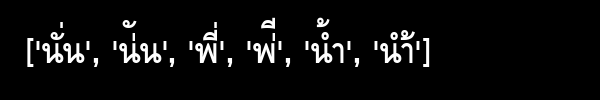

In [7]:
from PIL import Image, ImageFont, ImageDraw

text_string = str(['นั่น', 'น่ัน', 'พี่', 'พ่ี', 'น้ำ', 'นำ้'])

img = Image.new('RGB', (600, 100))
draw = ImageDraw.Draw(img)
font = ImageFont.truetype('trdg/fonts/th/upcdb.ttf', 50, layout_engine=ImageFont.Layout.RAQM)

draw.text((25,40), text_string, fill='white', font=font)

display(img)